## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [1]:
import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

reload(data_loading)
reload(experiment)
reload(rnn)
reload(umap)

2023-01-12 14:26:01.810401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:26:10.927719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'analysis.umap_analysis' from '/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/analysis/umap_analysis.py'>

In [2]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y, peptides = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is 0.6565247891915524


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


In [3]:
y_f_cutoff = 0.6565247891915524
y_p_cutoff = -0.4463856871323837

In [29]:
y_f = y[:,1] > y_f_cutoff 
y_p = y[:,0] > y_p_cutoff 

result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y_p, rnn.BinaryClassificationRNN# , load_trained_model=True
)
model = result.trained_model

Epoch 1/16
186/186 [==============================] - 11s 14ms/step - loss: 0.6247 - accuracy: 0.6620 - recall: 0.8949 - precision: 0.6353 - val_loss: 0.5931 - val_accuracy: 0.7140 - val_recall: 0.8350 - val_precision: 0.7094 - lr: 0.0010
Epoch 2/16
186/186 [==============================] - 1s 8ms/step - loss: 0.5829 - accuracy: 0.7163 - recall: 0.8892 - precision: 0.6851 - val_loss: 0.5783 - val_accuracy: 0.7254 - val_recall: 0.8889 - val_precision: 0.7029 - lr: 0.0010
Epoch 3/16
186/186 [==============================] - 1s 7ms/step - loss: 0.5753 - accuracy: 0.7195 - recall: 0.8927 - precision: 0.6872 - val_loss: 0.5694 - val_accuracy: 0.7292 - val_recall: 0.8936 - val_precision: 0.7051 - lr: 0.0010
Epoch 4/16
186/186 [==============================] - 1s 6ms/step - loss: 0.5707 - accuracy: 0.7220 - recall: 0.8935 - precision: 0.6894 - val_loss: 0.5679 - val_accuracy: 0.7284 - val_recall: 0.8862 - val_precision: 0.7068 - lr: 0.0010
Epoch 5/16
186/186 [==============================

In [30]:
reload(umap)
len(model.layers)
model.layers[4]
model.layers[0](X).shape
embedding=umap.embedding_regression_for_binary_classification_model(model,X)

(32911, 8)


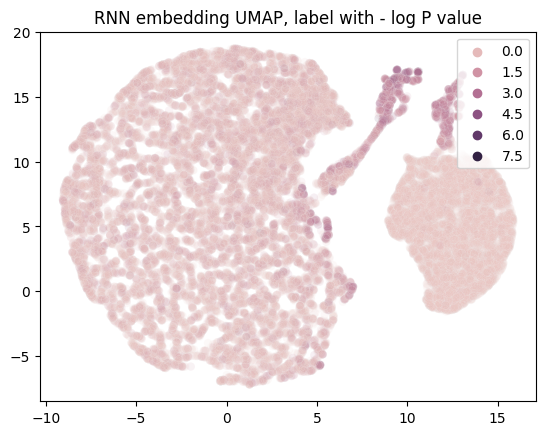

In [35]:
reload(umap)
umap.UMAP_log_P(embedding, y[:, 0])

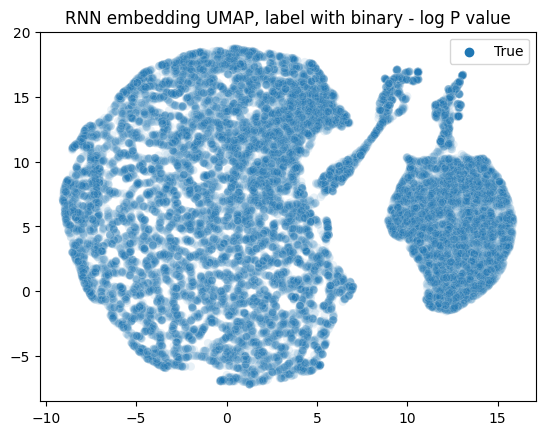

In [33]:
reload(umap)
umap.UMAP_binary_log_P(embedding, y_p, y_p_cutoff)

The model is somehow only learning the same thing for p-value and log fold :^(

## Load Data, Get Representation, Train Binary Classification RNN Model, CrossFold Best Model¶
(Binary classification on log fold change)

In [21]:
y_fc = y[:,1]> y_f_cutoff
y_p = y[:,0]

result1 = experiment.BinaryClassificationExperiment().run_cross_validation_experiment(
    X, y_fc, rnn.BinaryClassificationRNN
)

Epoch 1/16
206/206 [==============================] - 3s 5ms/step - loss: 0.1304 - accuracy: 0.8430 - recall_1: 0.1931 - precision_1: 0.7236
Epoch 2/16
206/206 [==============================] - 1s 5ms/step - loss: 0.1064 - accuracy: 0.8696 - recall_1: 0.3181 - precision_1: 0.8655
Epoch 3/16
206/206 [==============================] - 1s 5ms/step - loss: 0.1025 - accuracy: 0.8726 - recall_1: 0.3279 - precision_1: 0.8855
Epoch 4/16
206/206 [==============================] - 1s 6ms/step - loss: 0.0989 - accuracy: 0.8764 - recall_1: 0.3505 - precision_1: 0.8882
Epoch 5/16
206/206 [==============================] - 1s 5ms/step - loss: 0.0953 - accuracy: 0.8837 - recall_1: 0.4012 - precision_1: 0.8824
Epoch 6/16
206/206 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.8864 - recall_1: 0.4070 - precision_1: 0.9014
Epoch 7/16
206/206 [==============================] - 1s 5ms/step - loss: 0.0915 - accuracy: 0.8886 - recall_1: 0.4127 - precision_1: 0.9167
Epoch 8/16
20

In [23]:
model =result1[1].trained_model

In [24]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 1, X, y)    

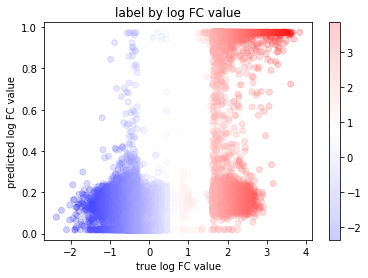

In [25]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_f_train, "log FC" , "log FC", "log FC")

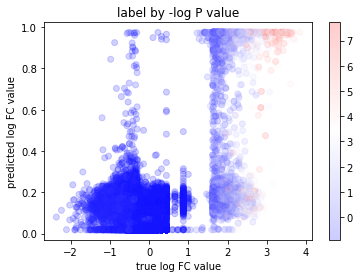

In [26]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_p_train, "log FC" , "log FC", "-log P")

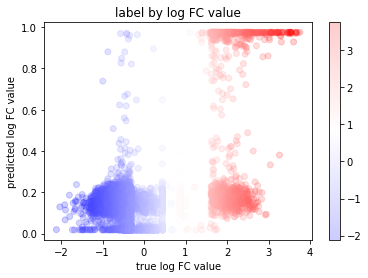

In [27]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_f_test, "log FC" , "log FC", "log FC")

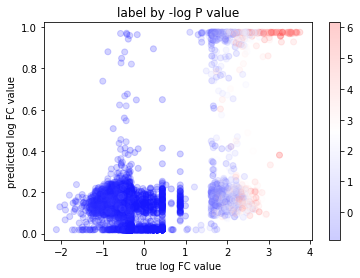

In [28]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_p_test, "log FC" , "log FC", "-log P")

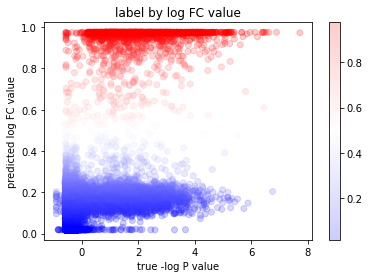

In [29]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train), model(X_train), "-log P" , "log FC", "log FC")

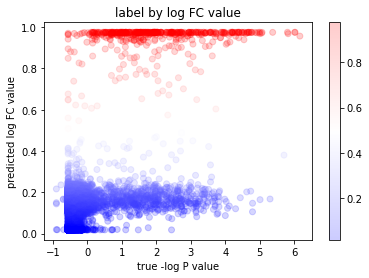

In [30]:
#Train samples classification results
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test), model(X_test), "-log P" , "log FC", "log FC")

In [31]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train),y_f_cutoff)

21601 53 2726 1949
accuracy 0.8944509856052262
precision 0.9735264735264735
recall 0.4168983957219251


In [32]:
embedding=umap.embedding_classification(model,X_train)

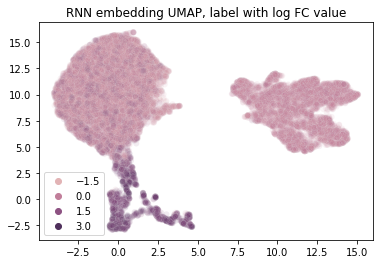

In [33]:
umap.UMAP_log_Fold(embedding, y_f_train)

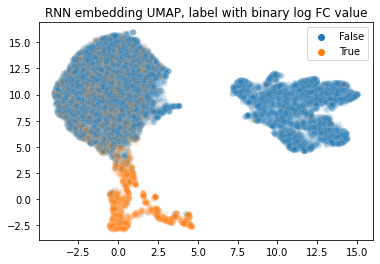

In [34]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

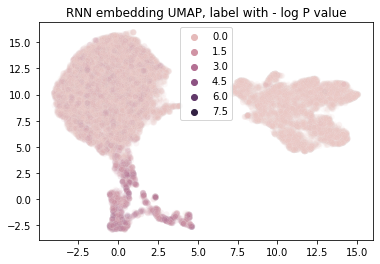

In [35]:
umap.UMAP_log_P(embedding, y_p_train)

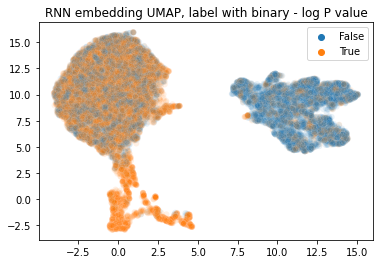

In [36]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

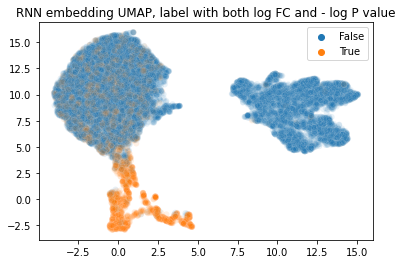

In [37]:
umap.UMAP_joint(embedding, y_f_train,y_f_cutoff, y_p_train, y_p_cutoff)

[(-4.0, 0.0)]

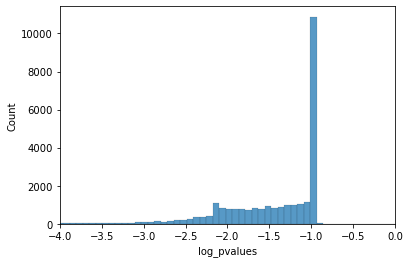

In [38]:
g=sns.histplot(R3_lib['log_pvalues'])
g.set(xlim=(-4,0))

<AxesSubplot: xlabel='log_pvalues', ylabel='Count'>

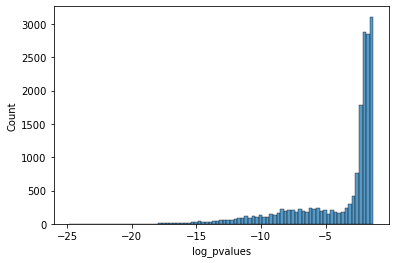

In [39]:
log_pvalues_cutoff = -R3_lib['log_pvalues'] > -np.log10(0.05)
sns.histplot(R3_lib.loc[log_pvalues_cutoff==True]['log_pvalues'])

In [40]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]>y_p_cutoff:
            if x2 >5.5:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [41]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [42]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('AYC', 68),
 ('ACF', 72),
 ('ACH', 74),
 ('ACT', 75),
 ('AAC', 78),
 ('ACR', 84),
 ('ALC', 92),
 ('ACY', 99),
 ('ACV', 115),
 ('ACL', 118),
 ('AGC', 122),
 ('ACG', 133),
 ('AVC', 142),
 ('ASC', 156),
 ('ACS', 164)]

In [43]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('ACS', 164)
('ASC', 156)
('AVC', 142)
('ACG', 133)
('AGC', 122)


## Load Data, Get Representation, Train single regression RNN Model

In [61]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y, peptides = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is 0.6565247891915524


In [62]:
y_f = y[:,1]>y_f_cutoff
y_p = y[:,0]

result2 = experiment.SingleRegressionExperiment().run_adhoc_experiment(
    X, y_f, rnn.SingleRegressionRNN
)

Epoch 1/16
186/186 [==============================] - 12s 62ms/step - loss: 0.1392 - fold_rmse: 0.1389 - val_loss: 0.1377 - val_fold_rmse: 0.1372 - lr: 0.0010
Epoch 2/16
186/186 [==============================] - 11s 60ms/step - loss: 0.1177 - fold_rmse: 0.1176 - val_loss: 0.1212 - val_fold_rmse: 0.1205 - lr: 0.0010
Epoch 3/16
186/186 [==============================] - 11s 62ms/step - loss: 0.1086 - fold_rmse: 0.1082 - val_loss: 0.1062 - val_fold_rmse: 0.1054 - lr: 0.0010
Epoch 4/16
186/186 [==============================] - 11s 59ms/step - loss: 0.1045 - fold_rmse: 0.1041 - val_loss: 0.1058 - val_fold_rmse: 0.1053 - lr: 0.0010
Epoch 5/16
186/186 [==============================] - 11s 56ms/step - loss: 0.1018 - fold_rmse: 0.1016 - val_loss: 0.1003 - val_fold_rmse: 0.0997 - lr: 0.0010
Epoch 6/16
186/186 [==============================] - 11s 57ms/step - loss: 0.0983 - fold_rmse: 0.0983 - val_loss: 0.1007 - val_fold_rmse: 0.1001 - lr: 9.0484e-04
Epoch 7/16
186/186 [======================

In [63]:
model =result2.trained_model

In [64]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

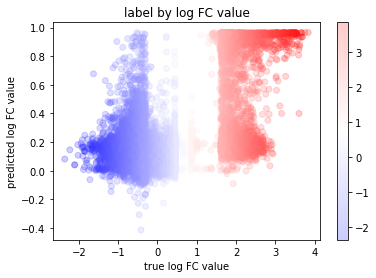

In [65]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_f_train, "log FC" , "log FC", "log FC")

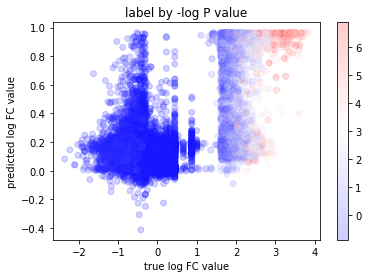

In [66]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train), y_p_train, "log FC" , "log FC", "-log P")

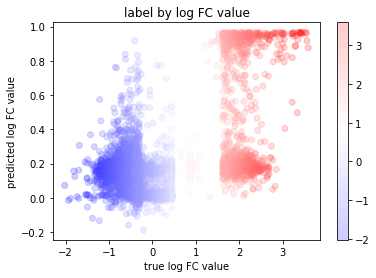

In [67]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_f_test, "log FC" , "log FC", "log FC")

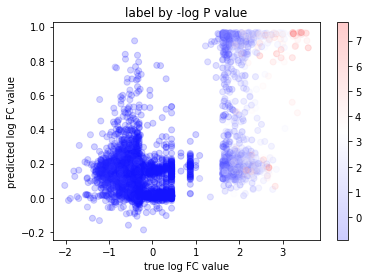

In [68]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test), y_p_test, "log FC" , "log FC", "-log P")

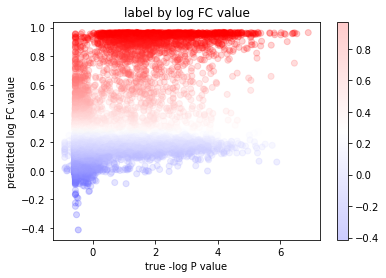

In [69]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train), model(X_train), "-log P" , "log FC", "log FC")

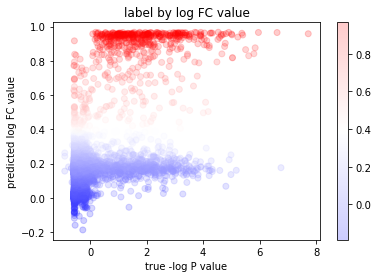

In [70]:
#Train samples classification results
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test), model(X_test), "-log P" , "log FC", "log FC")

In [71]:
# evaluate accuracy, precision, recall of trianed model
evaluation.single_regression_evaluation(y_f_train, model(X_train),y_f_cutoff)

21396 239 2613 2080
accuracy 0.8916742631419021
precision 0.8969383354894351
recall 0.44321329639889195


Text(0.5, 0, 'log_Fold')

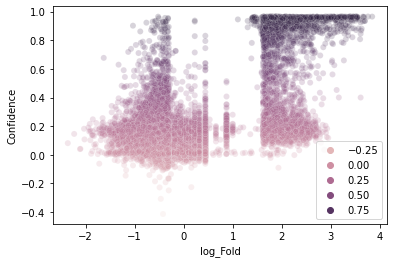

In [72]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train, y=model(X_train).numpy().reshape(-1), hue=model(X_train).numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [73]:
embedding=umap.embedding_regression(model,X_train)

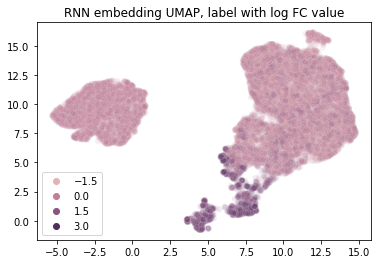

In [74]:
umap.UMAP_log_Fold(embedding, y_f_train)

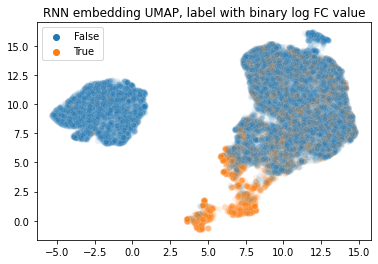

In [75]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

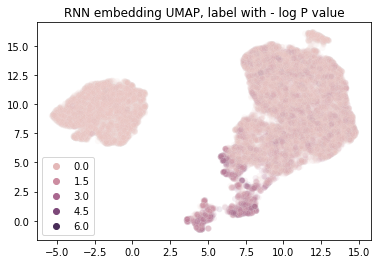

In [76]:
umap.UMAP_log_P(embedding, y_p_train)

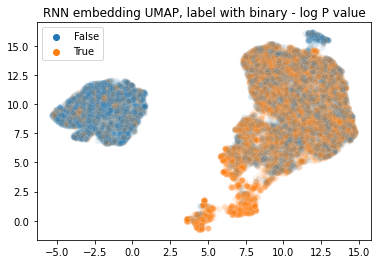

In [77]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

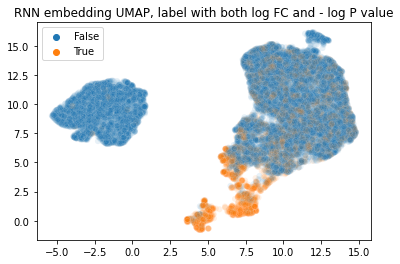

In [78]:
umap.UMAP_joint(embedding, y_f_train, y_f_cutoff, y_p_train, y_p_cutoff)

In [79]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x2 <3:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [80]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [81]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('CYG', 75),
 ('CLG', 79),
 ('LRD', 90),
 ('EDL', 91),
 ('PDY', 94),
 ('CGD', 101),
 ('DLR', 107),
 ('LGD', 117),
 ('AAC', 117),
 ('RDY', 128),
 ('YAA', 137),
 ('DYS', 161),
 ('YAC', 302),
 ('GDY', 558),
 ('DYA', 589)]

In [82]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 589)
('GDY', 558)
('YAC', 302)
('DYS', 161)
('YAA', 137)


## Load Data, Get Representation, Train Joint Regression RNN Model
(Joint Regression on log fold change & p-value)

In [45]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y, peptides = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is 0.6565247891915524


In [46]:
result = experiment.RegressionExperiment().run_adhoc_experiment(
    X, y, rnn.RegressionRNN, load_trained_model=False
)

Epoch 1/16
186/186 [==============================] - 21s 80ms/step - loss: 0.9377 - two_channel_mse: 0.9377 - fold_rmse: 0.9345 - p_value_rmse: 0.9345 - val_loss: 0.9407 - val_two_channel_mse: 0.9407 - val_fold_rmse: 0.9368 - val_p_value_rmse: 0.9368 - lr: 0.0010
Epoch 2/16
186/186 [==============================] - 12s 64ms/step - loss: 0.8349 - two_channel_mse: 0.8349 - fold_rmse: 0.8330 - p_value_rmse: 0.8330 - val_loss: 0.8332 - val_two_channel_mse: 0.8332 - val_fold_rmse: 0.8279 - val_p_value_rmse: 0.8279 - lr: 0.0010
Epoch 3/16
186/186 [==============================] - 11s 61ms/step - loss: 0.7674 - two_channel_mse: 0.7674 - fold_rmse: 0.7690 - p_value_rmse: 0.7690 - val_loss: 0.7966 - val_two_channel_mse: 0.7966 - val_fold_rmse: 0.7898 - val_p_value_rmse: 0.7898 - lr: 0.0010
Epoch 4/16
186/186 [==============================] - 12s 64ms/step - loss: 0.7287 - two_channel_mse: 0.7287 - fold_rmse: 0.7304 - p_value_rmse: 0.7304 - val_loss: 0.7141 - val_two_channel_mse: 0.7141 - va

In [47]:
y_f_cutoff = 0.6565247891915524
y_p_cutoff = -0.4463856871323837

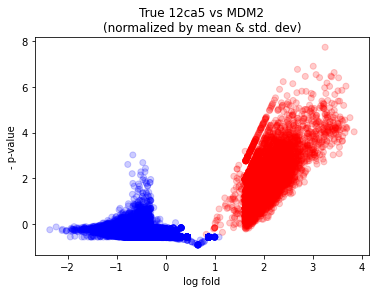

In [48]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], c =(y[:, 0]>y_p_cutoff)*(y[:, 1]>y_f_cutoff), cmap='bwr',alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

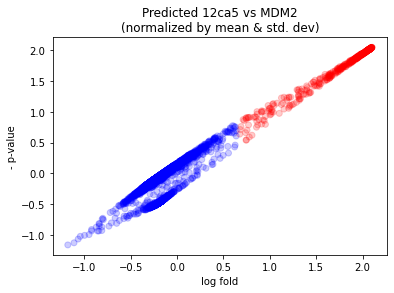

In [49]:
show_volcano(
    np.array(result.y_pred), protein_of_interest, other_protein, title_addendum="Predicted "
)

In [50]:
model =result.trained_model

In [51]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y)

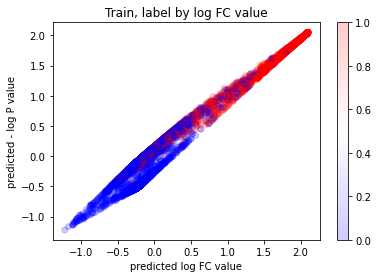

In [77]:
#Train samples classification results 
plt.ylabel("predicted - log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train)[:,1], model(X_train)[:,0], c=y_f_train> y_f_cutoff, cmap='bwr',alpha=0.2)
plt.title("Train, label by log FC value")
plt.colorbar()
plt.show()

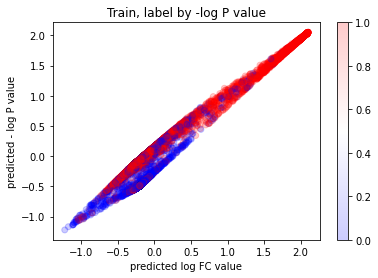

In [78]:
#Train samples classification results 
plt.ylabel("predicted - log P value")
plt.xlabel("predicted log FC value")
plt.scatter(model(X_train)[:,1], model(X_train)[:,0], c=y_p_train>y_p_cutoff, cmap='bwr',alpha=0.2)
plt.title("Train, label by -log P value")
plt.colorbar()
plt.show()

Text(0.5, 0, 'log_Fold')

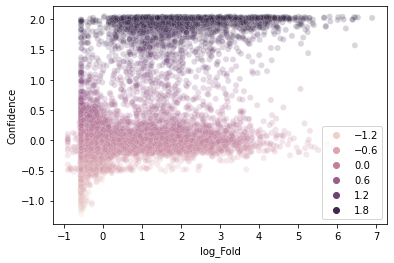

In [54]:
# confidence analysis
ax = sns.scatterplot(x=y_p_train, y=model(X_train)[:,0].numpy().reshape(-1), hue=model(X_train)[:,0].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

Text(0.5, 0, 'log_Fold')

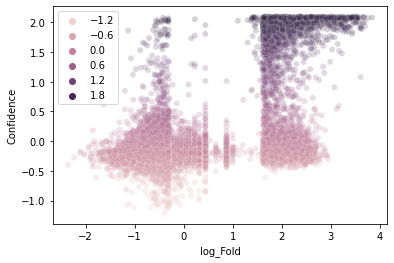

In [55]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

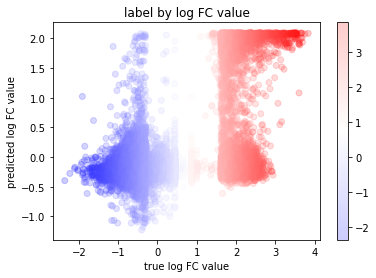

In [56]:
#Train samples classification results (TRAIN)
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train)[:,1], y_f_train, "log FC" , "log FC", "log FC")

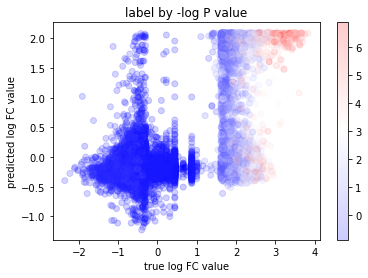

In [57]:
#Train samples classification results (TRAIN) 
scatter_plots.Predicted_vs_actual_plot(y_f_train, model(X_train)[:,1], y_p_train, "log FC" , "log FC", "-log P")

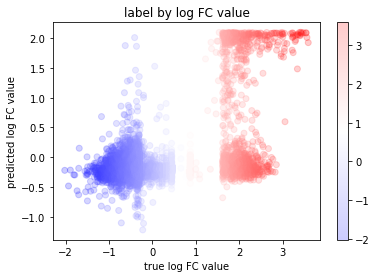

In [58]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test)[:,1], y_f_test, "log FC" , "log FC", "log FC")

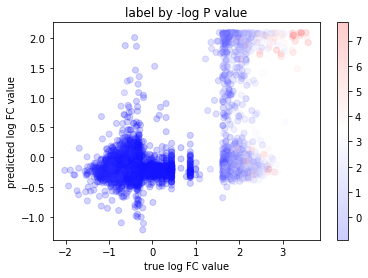

In [59]:
#Train samples classification results (TEST)
scatter_plots.Predicted_vs_actual_plot(y_f_test, model(X_test)[:,1], y_p_test, "log FC" , "log FC", "-log P")

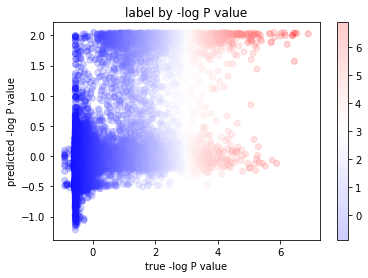

In [60]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train)[:,0], y_p_train, "-log P" , "-log P", "-log P")

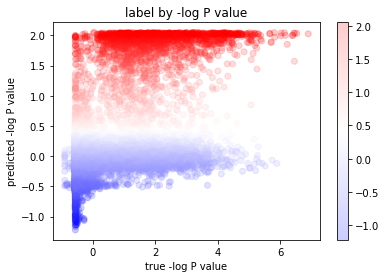

In [61]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_train, model(X_train)[:,0],model(X_train)[:,0], "-log P" , "-log P", "-log P")

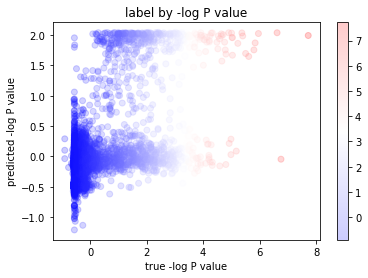

In [62]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test)[:,0], y_p_test, "-log P" , "-log P", "-log P")

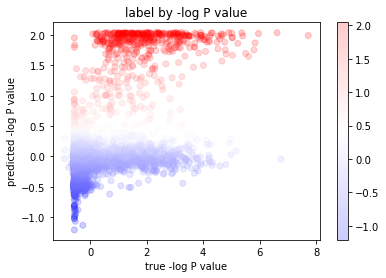

In [63]:
#Train samples classification results 
scatter_plots.Predicted_vs_actual_plot(y_p_test, model(X_test)[:,0], model(X_test)[:,0], "-log P" , "-log P", "-log P")

In [64]:
# evaluate accuracy, precision, recall of trianed model
evaluation.single_regression_evaluation(y_f_train, np.array(model(X_train)[:,1]), y_f_cutoff)

21446 189 2644 2049
accuracy 0.8923959282892738
precision 0.9155495978552279
recall 0.43660771361602385


In [65]:
# evaluate accuracy, precision, recall of trianed model
evaluation.joint_regression_evaluation(y_f_train, np.array(model(X_train)[:,1]), y_f_cutoff,y_p_train, np.array(model(X_train)[:,0]), y_p_cutoff )

21672 184 2428 2044
accuracy 0.900790033424491
precision 0.9174147217235189
recall 0.45706618962432916


In [66]:
embedding=umap.embedding_regression(model,X_train)

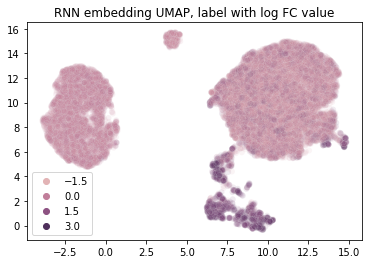

In [67]:
umap.UMAP_log_Fold(embedding, y_f_train)

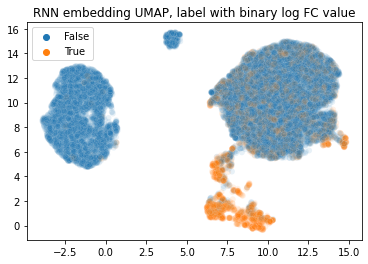

In [68]:
umap.UMAP_binary_log_Fold(embedding, y_f_train, y_f_cutoff)

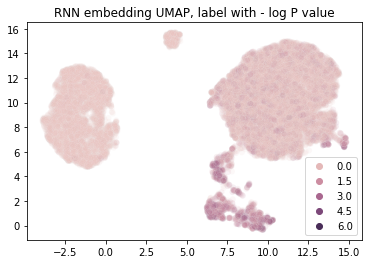

In [69]:
umap.UMAP_log_P(embedding, y_p_train)

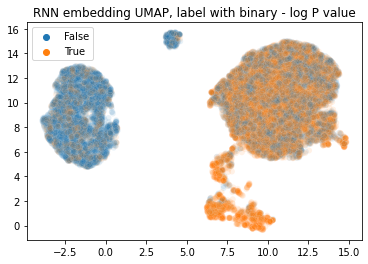

In [70]:
umap.UMAP_binary_log_P(embedding, y_p_train, y_p_cutoff)

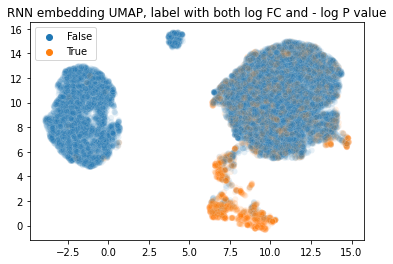

In [71]:
umap.UMAP_joint(embedding,y_f_train, y_f_cutoff, y_p_train,y_p_cutoff)

In [72]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i]>y_f_cutoff:
        if y_p_train[i]> y_p_cutoff:
            if x2 <4.0:
                true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [1]:
good_seqs
from analysis.shapley_additive_analysis import shapley_analysis, INVESTIGATION_TYPE


NameError: name 'good_seqs' is not defined

In [73]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [74]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('ACG', 74),
 ('AYC', 78),
 ('EDL', 89),
 ('LRD', 90),
 ('PDY', 95),
 ('DLR', 104),
 ('LGD', 107),
 ('CGD', 107),
 ('AAC', 114),
 ('YAA', 125),
 ('RDY', 130),
 ('DYS', 163),
 ('YAC', 321),
 ('GDY', 580),
 ('DYA', 620)]

In [75]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 620)
('GDY', 580)
('YAC', 321)
('DYS', 163)
('RDY', 130)


## Previous code

In [11]:
# Load other data libraries 
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
R2_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R2.csv")
R1_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R1.csv")

ImportError: cannot import name 'two_channel_mse' from 'models.rnn' (/Users/yitongtseo/Documents/GitHub/ml_phage_display/./src/models/rnn.py)

## Investigate Input Data

<AxesSubplot: xlabel='c_cnt', ylabel='Count'>

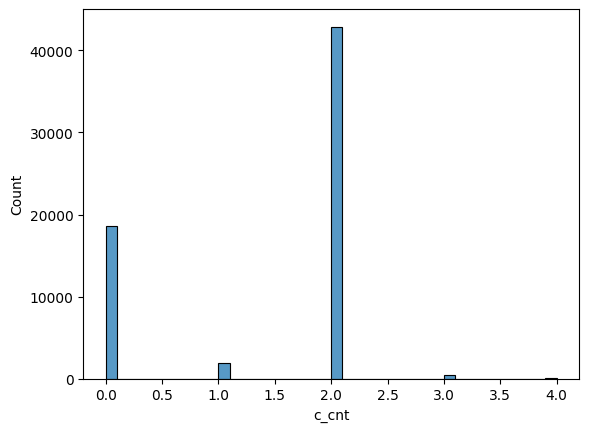

In [9]:
import seaborn as sns
sns.histplot(R3_lib['c_cnt'])

In [10]:
log_ratio_12ca5, _, _ = data_loading.build_dataset(R3_lib, protein_of_interest='12ca5')
sns.histplot(log_ratio_12ca5[R3_lib.is_dya==True], binwidth=0.2)
plt.title('DYA peptide')

IndexError: list index out of range

In [21]:
sns.histplot(log_ratio_12ca5[R3_lib.is_lle==True], binwidth=0.2, alpha=0.5)
plt.title('LLE peptide')

KeyError: '12ca5_log_ratio'

In [22]:
print((R3_lib.loc[R3_lib.is_lle==True]['12ca5_log_ratio']>0).sum())
print((R3_lib.loc[R3_lib.is_lle==True]['12ca5_log_ratio']<=0).sum())

KeyError: '12ca5_log_ratio'

Text(0.5, 1.0, 'all peptide')

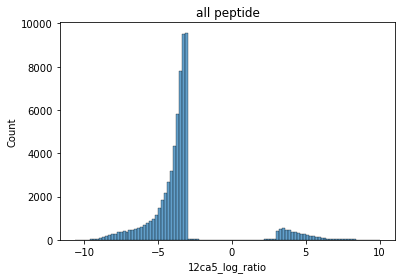

In [ ]:
sns.histplot(R3_lib['12ca5_log_ratio'], binwidth=0.2, alpha=0.7)
plt.title('all peptide')
# sns.histplot(R3_lib.loc[R3_lib.is_dya==True]['12ca5_log_ratio'], binwidth=0.2)

### model performance results

In [ ]:
print(acc)
print(pre)
print(rec)

[0.6483550832226304, 0.6542158318355865, 0.6634104407627384, 0.6598937167864958, 0.6517661769302907]
[0.6417112299465241, 0.6702702702702703, 0.6440677966101694, 0.7009803921568627, 0.751937984496124]
[0.026356248627278717, 0.027629233511586453, 0.026158788435061954, 0.03225078935498421, 0.021455430214554302]


In [ ]:
print(np.array(acc).mean(), np.array(acc).var())
print(np.array(pre).mean(), np.array(pre).var())
print(np.array(rec).mean(), np.array(rec).var())

0.6555282499075484 2.9703237664053927e-05
0.6817935346959902 0.0016901974856322836
0.026770098028693123 1.1913351182601678e-05


### umap

In [ ]:
# get the 4th fold because the 4th model showed the best precision
# actually unnecessary, can just use whatever fold
kf = KFold(n_splits=2)
i = 0
y_reg = np.array(list(y_reg))
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_reg_train, y_reg_test = y_reg[train_index], y_reg[test_index]
    if i==0:
        break
    i += 1

In [ ]:
embedding = reducer.fit_transform(nn_emb)

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

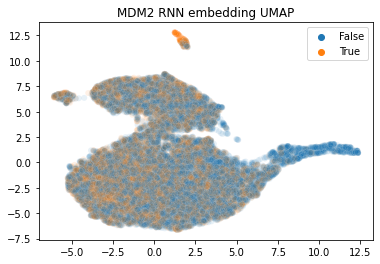

In [ ]:
# tests
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

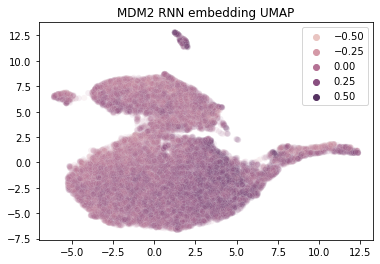

In [ ]:
# tests
X_train_prop1 = X_train[:,:,2].mean(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop1, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

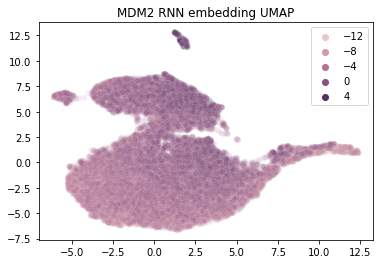

In [ ]:
# color by volume of side chain
X_train_prop2 = X_train[:,:,10].sum(-1)#.sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

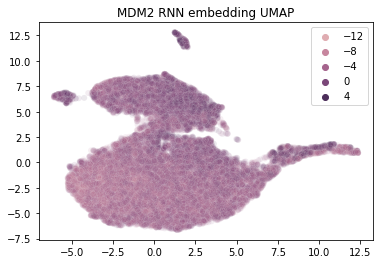

In [ ]:
# color by SASA
X_train_prop2 = X_train[:,:,9].sum(-1)#.sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

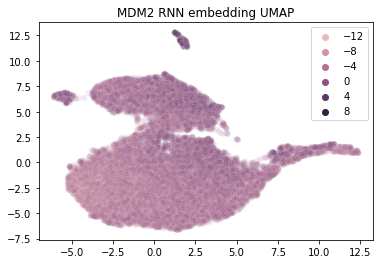

In [ ]:
# color by polarizability
X_train_prop2 = X_train[:,:,8].sum(-1)
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=X_train_prop2, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

In [ ]:
# write results
with open('mdm2_good.txt','w') as fh:
    for i in range(len(ls)):
        fh.write(f'{ls[i]}\n')

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 1:
        if x2 > 10.0:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
good_seqs

['AFCDWFACY',
 'ACKPFMCWW',
 'AFCDWFKCN',
 'AFCDWYCCS',
 'ACSCFECFW',
 'AYCVWVWCS',
 'AFCDWLWCS',
 'AFCDRFWCS',
 'AFCYWCWCS',
 'AFCDGLWCS',
 'WSLNSGMFGYQW',
 'AFCDCVWCS',
 'AFCDCFLCS',
 'AFWDWFWCA',
 'ACVSFECFW',
 'AFCDWYECN',
 'ALCGFWFCD',
 'AFCVWFECY',
 'AFFDWFWCS',
 'ACECFSCWW',
 'ACSTFECWW',
 'ACKCFMCWW',
 'AYCYWFWCS',
 'ACMTFMCWC',
 'ACCDWFWCS',
 'AFKTFMCWW',
 'AFCFWFWCS',
 'ACDSFSCWW',
 'AFCDYFYCS',
 'AVCFLEWCS',
 'ALCVWVWCS',
 'AFCWFDSCQ',
 'AFCYLFWCS',
 'AFCDLFWCD',
 'ACETFMCWW',
 'AFCDWLWCP',
 'AYCVWFWCS',
 'AYCDWFECN',
 'ACMTFMCWW',
 'ACSTFEWFW',
 'AFFDCFWCS',
 'AFFAWFWCS',
 'AFCAWFWWS',
 'ACKTFLCWW',
 'AFCVWVWCC',
 'ACKTFMFWW',
 'ACTTFEWWW',
 'AFCVWFLCC',
 'AFCDWFVCY',
 'AFCVWFWRS',
 'ACYTFMCWW',
 'AFCYWVWCS',
 'AFCDWYWCS',
 'AYCDWFECN',
 'AFCVWVWGS',
 'AFCAWFWCS',
 'AFCDWVWCS',
 'ACWWWSYCS',
 'AFCVWVWCS',
 'AFWVWFWCS',
 'AFCDWFESN',
 'AFCVRFWCS',
 'ACYTFMCWW',
 'AFCDGVWCS',
 'AFCYWLWCS',
 'ALCDWFWCS',
 'AFCVWFWCS',
 'AFCDWFECY',
 'ACSPFECFW',
 'AFFFWFWCS',
 'AFCDWSWCS',
 'A

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

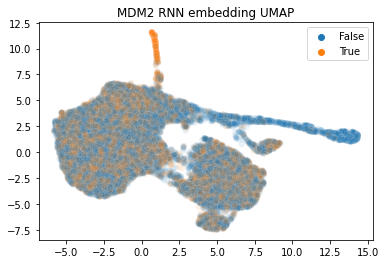

In [ ]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

### confidence analysis

In [ ]:
y_pred = model(X_train)

Text(0.5, 0, 'MDM2_log_ratio')

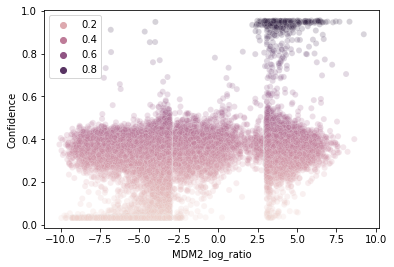

In [ ]:
# colored by predicted confidence
ax = sns.scatterplot(x=y_mdm2_reg_train, y=y_pred.numpy().reshape(-1), hue=y_pred.numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('MDM2_log_ratio')

Text(0.5, 0, 'MDM2_log_ratio')

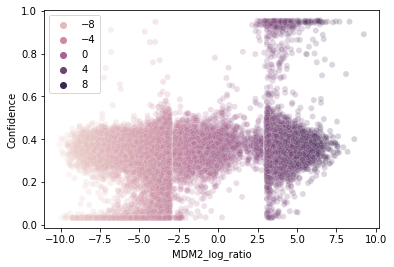

In [ ]:
# colored by true log ratio 
ax = sns.scatterplot(x=y_reg_train, y=y_pred.numpy().reshape(-1), hue=y_reg_train, alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('MDM2_log_ratio')

Text(0.5, 1.0, 'MDM2 RNN embedding UMAP')

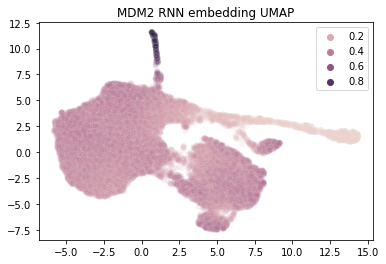

In [ ]:
# colored by predicted confidence
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_pred.numpy().reshape(-1), alpha=0.1)
plt.title("MDM2 RNN embedding UMAP")

### get samples from putative binder cluster

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 0:
        if x1 > 10.0:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
len(good_seqs)

1133

In [ ]:
good_seqs

['AVCGDYAEC',
 'KDVFRDY',
 'ACLGDYACR',
 'ACVGDYAAC',
 'DYPDYAD',
 'MADSPDY',
 'ACYGDYACF',
 'AGCGDYAAG',
 'DWGDYAL',
 'AHCYGDYAC',
 'DDYLDYS',
 'ACWDYACYV',
 'ACWEGEYAC',
 'KVELRDY',
 'AFCLGDYSC',
 'NEDLMDY',
 'AECGDYAEC',
 'AYCFGDYSC',
 'ACLGDYSHC',
 'ACFDADYSEC',
 'ADCYGDYAC',
 'AKCWGDYAC',
 'AQCFGDYAC',
 'ALCGDYSAC',
 'ACGDYAVVC',
 'ACVVDYACW',
 'ACMGDYASC',
 'KDDLWDY',
 'NEDLLYY',
 'TADMPDY',
 'ACYCDYACA',
 'MKDVVDY',
 'DARDYAG',
 'KEDLSYY',
 'AGWMTWCEE',
 'ACYVDYAAC',
 'ARCVGDYGC',
 'LMDWPDY',
 'AHCGDYAEC',
 'AVWWGDYAC',
 'ASCVGDYSC',
 'DEKDYAA',
 'KVDLGDF',
 'ACYGDYAGC',
 'DLYDYAH',
 'SEVYDYS',
 'ACAADLRDY',
 'AGCYGDYDC',
 'ADRRDYA',
 'ARCVGDYAF',
 'ATCVGDYAC',
 'DTMDYAY',
 'ACTGDYAWC',
 'ACNFDYACW',
 'ALCSGDYAC',
 'ACFADYACL',
 'ACNLPWCEE',
 'RLDKPDY',
 'LADLHDY',
 'AFCVGDYAC',
 'ACLGDYACK',
 'HAVGFDY',
 'AKCFGDYAW',
 'ACAADMRDY',
 'AHCDVMDYG',
 'AFCLGEYAC',
 'ACVGDYAGC',
 'AAWGDYAAC',
 'ACYGDYACY',
 'QHDYPDY',
 'SDTGDYA',
 'ACGMTWCEE',
 'ARCYGDYDC',
 'APCADYACW',
 'ACCFDLGDY',

In [ ]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [ ]:
for seq in ninemer_seq:
    print(seq)

VCGDYAEC
CLGDYACR
CVGDYAAC
CYGDYACF
GCGDYAAG
HCYGDYAC
CWDYACYV
CWEGEYAC
FCLGDYSC
ECGDYAEC
YCFGDYSC
CLGDYSHC
DCYGDYAC
KCWGDYAC
QCFGDYAC
LCGDYSAC
CGDYAVVC
CVVDYACW
CMGDYASC
CYCDYACA
GWMTWCEE
CYVDYAAC
RCVGDYGC
HCGDYAEC
VWWGDYAC
SCVGDYSC
CYGDYAGC
CAADLRDY
GCYGDYDC
RCVGDYAF
TCVGDYAC
CTGDYAWC
CNFDYACW
LCSGDYAC
CFADYACL
CNLPWCEE
FCVGDYAC
CLGDYACK
KCFGDYAW
CAADMRDY
HCDVMDYG
FCLGEYAC
CVGDYAGC
AWGDYAAC
CYGDYACY
CGMTWCEE
RCYGDYDC
PCADYACW
CCFDLGDY
CNGDYAAF
GGLGDYAR
GCWGDYAG
DCGGYCGY
VCWGDYEC
CPCDYAAC
RCAGDYAC
CVWRWCEE
LCQGDYAC
CRATWWEE
CVGDYACA
QCYGDYSC
CVFTFCEE
CWLTWCEE
PCGDYAAC
CLGYYAAC
YCVGDYAC
CVGDYACP
VCWGDYVC
RCWDYACY
ACFGDYAW
ACFGDYAF
CWWTWCEE
CCDYAAYC
CTGDYAAC
LCYGDYAC
CFGDYASC
VCGGDYAC
GCYGDYVC
CRGDFAAC
RCYWDYAC
GCVGDYAW
VCLGDYAG
HCGDYSAC
CPDYAACF
CWDGEYAC
CWMTWGEE
LCFCDYAC
MCWGDYAC
CFGYAAYC
LCFGDYAG
CPGDYSTC
MCYGDYSC
CYGDYASC
YCFGDYAW
CYGYYAAC
CAADRLDY
CSVDYAAC
CVGDYACS
LCGDYAAC
FCHGDYAF
GWLGDYAG
ACYGDYAC
CWMRWCEE
ECLGDYAR
CYFTWCEE
WRGDYAMC
CWLRWCEE
CYGDYACR
RCVGDYSC
CGDYSATC
GCYGDYEC
G

## 12ca5

In [ ]:
y = R3_lib['12ca5_log_ratio']
y = np.array(list(y.apply(lambda e: e > 0)))
X, y = shuffle(nn_x, y, random_state=0)

### train model

In [ ]:
models = []
kf = KFold(n_splits=5)
acc, pre, rec = [], [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    model.fit(
        x=X_train,
        y=y_train,
        batch_size=128,
        epochs=16,
        verbose='auto',
        validation_split=0.1,
        initial_epoch=0,
        class_weight={1:0.8, 0:0.2},
        validation_freq=1,
        use_multiprocessing=False)
    
    y_pred = model(X_test)
    y_pred = y_pred.numpy().reshape(-1) >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(tn, fp, fn, tp)
    print("accuracy", (tn+tp)/(tn+fp+fn+tp))
    acc.append((tn+tp)/(tn+fp+fn+tp))
    print("precision", tp/(tp+fp))
    pre.append(tp/(tp+fp))
    print("recall", tp/(tp+fn))
    rec.append(tp/(tp+fn))
    models.append(model)

# do not trust the accuracy score here, it was wrongly implemented before (it's fine now)

Epoch 1/16
360/360 [==============================] - 7s 10ms/step - loss: 0.1145 - accuracy: 0.9132 - recall_6: 0.3721 - precision_6: 0.5076 - val_loss: 0.2706 - val_accuracy: 0.9271 - val_recall_6: 0.4262 - val_precision_6: 0.6788
Epoch 2/16
360/360 [==============================] - 3s 8ms/step - loss: 0.1006 - accuracy: 0.9287 - recall_6: 0.4497 - precision_6: 0.6320 - val_loss: 0.2840 - val_accuracy: 0.9265 - val_recall_6: 0.4699 - val_precision_6: 0.6513
Epoch 3/16
360/360 [==============================] - 3s 8ms/step - loss: 0.0973 - accuracy: 0.9339 - recall_6: 0.4536 - precision_6: 0.6873 - val_loss: 0.2818 - val_accuracy: 0.9269 - val_recall_6: 0.4719 - val_precision_6: 0.6542
Epoch 4/16
360/360 [==============================] - 3s 8ms/step - loss: 0.0956 - accuracy: 0.9372 - recall_6: 0.4606 - precision_6: 0.7238 - val_loss: 0.2607 - val_accuracy: 0.9375 - val_recall_6: 0.4699 - val_precision_6: 0.7766
Epoch 5/16
360/360 [==============================] - 3s 8ms/step - los

### results

In [ ]:
kf = KFold(n_splits=5)
acc, pre, rec = [], [], []
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = models[i]
    y_pred = model(X_test)
    y_pred = y_pred.numpy().reshape(-1) >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(tn, fp, fn, tp)
    print("accuracy", (tn+tp)/(tn+fp+fn+tp))
    acc.append((tn+tp)/(tn+fp+fn+tp))
    print("precision", tp/(tp+fp))
    pre.append(tp/(tp+fp))
    print("recall", tp/(tp+fn))
    rec.append(tp/(tp+fn))
    
    i+=1
    if i==5:
        break

11626 85 592 494
accuracy 0.9470969758537157
precision 0.853195164075993
recall 0.4548802946593002
11468 173 602 554
accuracy 0.939438930999453
precision 0.7620357634112792
recall 0.47923875432525953
11493 200 597 506
accuracy 0.9377149109096593
precision 0.71671388101983
recall 0.4587488667271079
11566 72 638 520
accuracy 0.9445139105970616
precision 0.8783783783783784
recall 0.44905008635578586
11518 169 588 521
accuracy 0.9408408877774305
precision 0.755072463768116
recall 0.4697926059513075


In [ ]:
print(np.array(acc).mean(), np.array(acc).var())
print(np.array(pre).mean(), np.array(pre).var())
print(np.array(rec).mean(), np.array(rec).var())

0.9419211232274639 1.170648113987608e-05
0.7930791301307194 0.003825949573193828
0.46234212160375215 0.00011725489146586728


Text(0.5, 0, '12ca5_log_ratio')

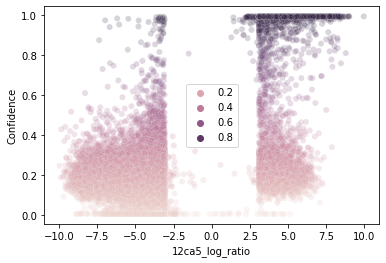

In [ ]:
# confidence analysis
ax = sns.scatterplot(x=y_12ca5_reg_train, y=y_pred.numpy().reshape(-1), hue=y_pred.numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('12ca5_log_ratio')

### umap

In [ ]:
model = models[3] # third model showed the best precision
y_pred = model(X_train)

In [ ]:
kf = KFold(n_splits=5)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if i==3:
        break
    i += 1

In [ ]:
nn_emb = model.layers[2](model.layers[1](model.layers[0](X_train)))
reducer = umap.UMAP(n_neighbors=10,
                    min_dist=0.1,
                    n_components=2)

In [ ]:
embedding = reducer.fit_transform(nn_emb)

Text(0.5, 1.0, '12ca5 RNN embedding UMAP')

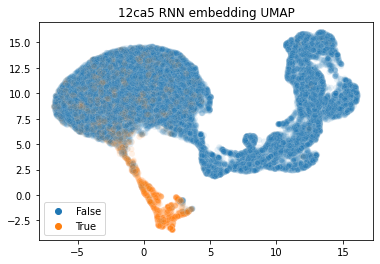

In [ ]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=y_train, alpha=0.1)
plt.title("12ca5 RNN embedding UMAP")

### find samples from the putative binder cluster

In [ ]:
true_cluster = []
good_seqs = []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_train[i] == 1:
        if x2 < 1.2:
            true_cluster.append(X_train[i,:,1])
for feature in true_cluster:
    good_seqs.append(RAA_to_seq(feature))

In [ ]:
ninemer_seq = []
for seq in ninemer_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:]) # exclude 'A' in position 0 

In [ ]:
len(good_seqs)

1689

In [ ]:
# write results
with open('12ca5_good.txt','w') as fh:
    for i in range(len(ls)):
        fh.write(f'{ls[i]}\n')

In [2]:
good_seqs

NameError: name 'good_seqs' is not defined

In [ ]:
for seq in ninemer_seq:
    print(seq)

FCLGDFAC
HCTDRRDY
VCGDYAEC
CLGDYACR
CVGDYAAC
CYGDYACF
GCGDYAAG
HCYGDYAC
CWEGEYAC
FCLGDYSC
ECGDYAEC
YCFGDYSC
CLGDYSHC
DCYGDYAC
KCWGDYAC
RCVGVYAC
QCFGDYAC
LCGDYSAC
GCRMLECR
CGDYAVVC
CVVDYACW
CMGDYASC
VCTYLECK
TCLDYACW
PCFHLEWR
PCFHLECR
CNFSLCEE
GWMTWCEE
CYVDYAAC
RCVGDYGC
HCGDYAEC
VWWGDYAC
SCVGDYSC
KCWGDFAC
CSYTWWEE
CYGDYAGC
CSGYYAAC
CWVYACME
VCFHLECR
VCSMLECK
CAADLRDY
GCYGDYDC
RCVGDYAF
TCVGDYAC
CTGDYAWC
CNFDYACW
LCSGDYAC
CFADYACL
CWDYACWP
CNLPWCEE
GCPMLECK
CRSTWCEE
FCVGDYAC
CLGDYACK
VCPMLECQ
TCFLLECK
KCFGDYAW
CAADMRDY
HCDVMDYG
PCTLMECR
FCLGEYAC
CQHTSCEE
CVGDYAGC
AWGDYAAC
CYGDYACY
CGMTWCEE
RCYGDYDC
PCADYACW
CCFDLGDY
CNGDYAAF
GGLGDYAR
CVGDSACQ
SCFVYACW
GCWGDYAG
HCFHLECR
TCFHLECR
NCTLLECR
YCTLLECR
VCWGDYEC
CPCDYAAC
PCLLLECK
RCAGDYAC
CVWRWCEE
LCQGDYAC
CFAYQCEE
CRATWWEE
CVGDYACA
QCYGDYSC
CVFTFCEE
CWLTWCEE
CSNTLCEE
PCGDYAAC
GCLGDFAC
CLGYYAAC
YCVGDYAC
CVGDYACP
VCWGDYVC
ACFGDYAW
ACFGDYAF
VCPMLECR
CWWTWCEE
CTGDYAAC
LCYGDYAC
CFGDYASC
VCGGDYAC
CFGVYAAC
GCYGDYVC
CDYADQSC
QCFMLECR
CSNTGCEE
RCYWDYAC
C

### 3mer frequency detection

In [ ]:
Dict_3mer_occ = {}
for tmer in Dict_3mer_to_100vec.keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('ACG', 83),
 ('CLG', 85),
 ('LRD', 88),
 ('PDY', 88),
 ('CGD', 106),
 ('DLR', 107),
 ('RDY', 118),
 ('LEC', 120),
 ('LGD', 123),
 ('AAC', 123),
 ('YAA', 139),
 ('DYS', 171),
 ('YAC', 314),
 ('GDY', 552),
 ('DYA', 589)]

In [ ]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 589)
('GDY', 552)
('YAC', 314)
('DYS', 171)
('YAA', 139)
